## Set up

In [46]:
# Basic libraries 
import numpy as np
import pandas as pd
import datetime as dt
import random
from utils import *
seed = 17
np.random.seed(seed)

# Visualization libraries
import matplotlib as mpl
from matplotlib.pyplot import plot
from matplotlib.gridspec import GridSpec

# Visualization parameters
%matplotlib notebook

In [47]:
#%reset

# Part 4: Training and testing

Let's deal with test loop first as we're gonna call it from time to time in our training loop.  
Logic in here is pretty simple: we feed an observation to our agent, get it's decision back, feed it to our environment and repeat the cycle.

# Part 4:  Visualization

How are we to understand what exactly our agent is doing without proper visualization? That's why we need to create a visualized `testsight` in order to see if our model is actually learning anything. Let's create a separate class just for that.

In [48]:
class Visualizer:
    def __init__(self, actions):
        
        self.actions = actions
        # Main window and it's axes
        fig = plt.figure(figsize=(9.5,24))
        gs = GridSpec(8, 8, figure=fig)
        axs = {}
        axs["Balance"] = fig.add_subplot(gs[0, :])
        axs["Balance"].set_xlim([-50,850])
        axs["Episode"] = fig.add_subplot(gs[1, :])
        axs["Agent decisions"] = fig.add_subplot(gs[2, :-3])
        axs["Info"] = fig.add_subplot(gs[2, -3:])
        axs["Training episode reward"] = fig.add_subplot(gs[3, :])
        axs["Training final reward"] = fig.add_subplot(gs[4, :])
        axs["Training balance"] = fig.add_subplot(gs[5, :])
        axs["Test reward"] = fig.add_subplot(gs[6, :])
        axs["Test balance"] = fig.add_subplot(gs[7, :])

        # Initializing some settings for axes
        for title, ax in axs.items():
            if title != "Info":
                ax.set_title(title, fontsize=12)
                ax.grid(c="xkcd:silver")
                ax.set_facecolor('xkcd:white')
                ax.margins(0.1,0.1)
                ax.set_xlabel("Epoch")

        axs["Balance"].set_xlabel("Step", fontsize=12)
        axs["Episode"].set_xlabel("Date", fontsize=12)
        axs["Agent decisions"].set_xlabel("Step", fontsize=12)
        axs["Agent decisions"].tick_params("x", labelsize=8) 
        axs["Agent decisions"].grid(False)
        axs["Info"].grid(False)
        axs["Info"].tick_params(which='both', left=False, bottom=False, top=False, labelbottom=False, labelleft=False)

        text = {}
        text["test"] = axs["Info"].annotate("Test:", xy=(0.05,0.9),xycoords='axes fraction', fontsize=11)
        text["balance"] = axs["Info"].annotate("Balance:", xy=(0.05,0.8),xycoords='axes fraction', fontsize=11)
        text["epsilon"] = axs["Info"].annotate("Epsilon:", xy=(0.05,0.7),xycoords='axes fraction', fontsize=11)
        text["last_reward"] = axs["Info"].annotate("Last reward:", xy=(0.05,0.6),xycoords='axes fraction', fontsize=11)
        text["episode_reward"] = axs["Info"].annotate("Episode reward:", xy=(0.05,0.5),xycoords='axes fraction', fontsize=11)
        text["episode"] = axs["Info"].annotate("Episode:", xy=(0.05,0.4),xycoords='axes fraction', fontsize=11)
        text["start_time"] = axs["Info"].annotate("Start time:", xy=(0.05,0.3),xycoords='axes fraction', fontsize=11)
        text["current_time"] = axs["Info"].annotate("Current time:", xy=(0.05,0.2),xycoords='axes fraction', fontsize=11)
  
        lines = {}
        lines["balance"] = axs["Balance"].plot(0, 0, c="xkcd:azure", linewidth=2)[0]
        lines["episode"] = axs["Episode"].plot(pd.Timestamp("01-01-1970 00:00:00"), 0, c="xkcd:azure", linewidth=2)[0]
        lines["episode_rt"] = axs["Episode"].plot(pd.Timestamp("01-01-1970 00:00:00"), 0, c="xkcd:green", linewidth=2)[0]
        lines["ag_decisions"] = axs["Agent decisions"].bar(actions, [0]*len(actions), color="darkgreen")
        lines["trer"] = axs["Training episode reward"].plot(0, 0, c="xkcd:azure", linewidth=1, marker="^", markersize=4)[0]
        lines["trfr"] = axs["Training final reward"].plot(0, 0, c="xkcd:azure", linewidth=1, marker="^", markersize=4)[0]
        lines["trb"] = axs["Training balance"].plot(0, 0, c="xkcd:azure", linewidth=1, marker="s", markersize=4)[0]   
        lines["ter"] = axs["Test reward"].plot(0, 0, c="crimson", linewidth=1, marker="^", markersize=4)[0]
        lines["teb"] = axs["Test balance"].plot(0, 0, c="crimson", linewidth=1, marker="s", markersize=4)[0] 
                
        bars_text = []
        for bar in lines["ag_decisions"]:
            height = bar.get_height()
            bars_text.append(axs["Agent decisions"].text(bar.get_x()+bar.get_width()/2, 1.01*height, str(height), va='bottom', ha='center'))
          
        self.fig = fig
        self.axs = axs
        self.lines = lines
        self.text = text
        self.bars_text = bars_text
        self.positions = []
        self.update_testsight(*self.axs.keys())
    
    def update_testsight(self, *axes):
        """
        Function that updates selected axes 
        """
        for ax in axes: 
            self.axs[ax].relim()
            self.axs[ax].autoscale_view(True,True,True)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        self.fig.tight_layout()

Now to create methods to update our visualizer.

In [49]:
def update_info(self, test, balance, epsilon, last_reward, ep_reward, episode, start_time, current_time=None):
    """
    Updates information fields
    """
    if test:
        self.text["test"].set_color("red")
        self.text["test"].set_text("Test: ON")
    else:
        self.text["test"].set_color("black")
        self.text["test"].set_text("Test: OFF")
    self.text["balance"].set_text("Balance: %.2f" % balance)
    self.text["epsilon"].set_text("Epsilon: %.5f" % epsilon)
    self.text["last_reward"].set_text("Last reward: %.4f" % last_reward)
    self.text["episode_reward"].set_text("Episode reward: %.4f" % ep_reward)
    self.text["episode"].set_text("Episode: %d" % episode)
    self.text["start_time"].set_text("Start time: %s" % start_time.strftime('%Y-%m-%d %H:%M:%S'))
    if current_time is not None:
        self.text["current_time"].set_text("Current time: %s" % current_time.strftime('%Y-%m-%d %H:%M:%S'))

    self.update_testsight("Info")
    

def on_day_start(self, dates, prices):
    """
    Set's graph info on a new day
    """
    self.lines["episode"].set_data(dates, prices)
    self.lines["episode_rt"].set_data(dates[0], prices[0]) 
    for position in self.positions:
        position.remove()
    self.positions = []

    self.update_testsight("Episode")

    
def __get_ls(self, array):
    """
    Creates a np.linspace
    """
    return np.linspace(1, len(array), len(array))
    
    
def update_graphs(self, balance_h, cur_dates, cur_prices, decision_dict, positions, test):
    """
    Updates balance and current episode history
    """
    if test:
        self.lines["balance"].set_color("crimson")
    else:
        self.lines["balance"].set_color("xkcd:azure")
    self.lines["balance"].set_data(self.__get_ls(balance_h), balance_h)
    self.lines["episode_rt"].set_data(cur_dates, cur_prices) 
    for i, bar in enumerate(self.lines["ag_decisions"]):
        height = decision_dict[self.actions[i]]
        bar.set_height(height)
        self.bars_text[i].set_y(1.01*height)
        self.bars_text[i].set_text(str(height))


    for position in positions:
        if position.open_date.date()==cur_dates[0].date() and position.open_date not in self.positions:
            marker = "^" if position.direction==1 else "v"
            if position.close_date is not None:
                color = "red" if (position.current_profit - position.transaction_cost*2) < 0 else "green"
                self.positions.append(self.axs["Episode"].plot([position.open_date, position.close_date],\
                                                                   [position.open_exchange_rate, \
                                                                   position.close_exchange_rate],\
                                                                   marker=marker, markersize=10, c=color)[0])
            else:
                self.positions.append(self.axs["Episode"].plot(position.open_date, position.open_exchange_rate,\
                                                                        marker=marker, markersize=10, c="yellow")[0])

    self.update_testsight("Balance", "Agent decisions", "Episode")


def update_history(self, trer, trfr, trb, ter, teb):
    """
    Updates history graphs
    """
    self.lines["trer"].set_data(self.__get_ls(trer), trer)
    self.lines["trfr"].set_data(self.__get_ls(trfr), trfr)
    self.lines["trb"].set_data(self.__get_ls(trb), trb)
    self.lines["ter"].set_data(self.__get_ls(ter), ter)
    self.lines["teb"].set_data(self.__get_ls(teb), teb)
    self.update_testsight("Training episode reward", "Training final reward","Training balance", "Test reward", "Test balance")

    
Visualizer.on_day_start = on_day_start
Visualizer.update_info = update_info
Visualizer.__get_ls = __get_ls
Visualizer.update_graphs = update_graphs
Visualizer.update_history = update_history

# Testing 

Let's test our testsight.

<IPython.core.display.Javascript object>


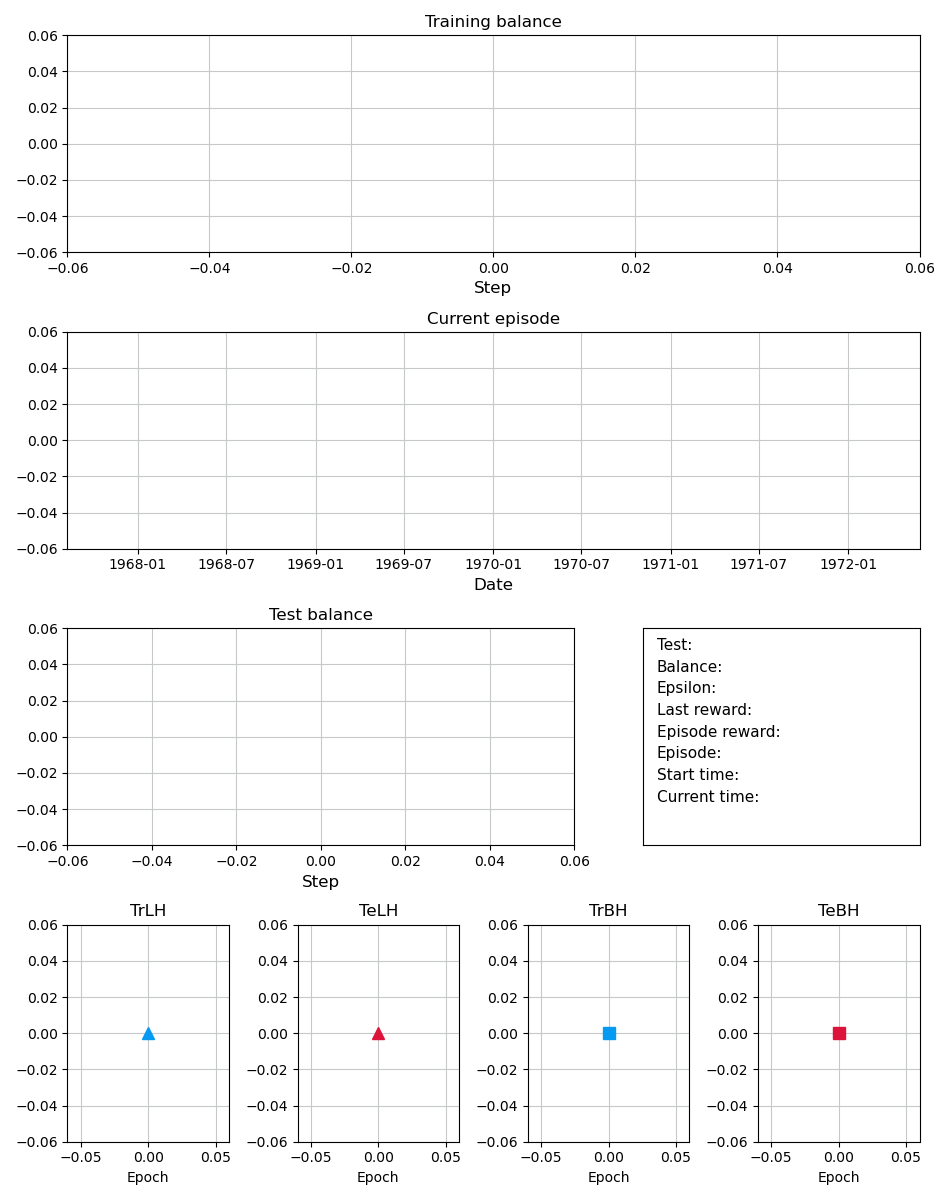

In [50]:
viz = Visualizer()